# GitHub Stars EDA
## Data Sources
- stars received: [Github Archive](https://www.gharchive.org/) bigquery's public data set, year 2022.

## Data loading

In [3]:
import pandas as pd
from google.cloud import bigquery
from google.oauth2 import service_account
import numpy as np

In [4]:
credentials = service_account.Credentials.from_service_account_file(
'.bigquery-eda-key.json')
project_id='github-eda'
client = bigquery.Client(credentials= credentials,project=project_id)

In [5]:
# stars received per user in 2022 (doesn't include users with no stars)
WATCH_EVENTS_PER_USER_QUERY= """
SELECT split(repo.name, '/')[OFFSET(0)] as user, count(*) as stars
FROM `githubarchive.year.2022`
where type = 'WatchEvent'
group by user
order by stars asc
"""

df_watch_events = client.query(WATCH_EVENTS_PER_USER_QUERY).to_dataframe()['stars']

In [6]:
# total number of users (with or without starred repos)
USERS_COUNT_QUERY = """
SELECT count(distinct(split(repo.name, '/')[OFFSET(0)])) as users_count
FROM `githubarchive.year.2022`
"""
users_count = client.query(USERS_COUNT_QUERY).to_dataframe()['users_count'][0]

## Data Exploration

In [7]:
df_watch_events.head()

0    1
1    1
2    1
3    1
4    1
Name: stars, dtype: Int64

In [8]:
df_watch_events.describe()

count    3.243376e+06
mean     1.742826e+01
std      4.948940e+02
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      5.683110e+05
Name: stars, dtype: float64

In [9]:
users_count

17690503

In [10]:
users_without_starred_repos = users_count - df_watch_events.count()
users_without_starred_repos

14447127

In [11]:
stars_series = np.concatenate((np.zeros((users_without_starred_repos,), dtype=int), df_watch_events.loc[:].to_list()
), axis=None)

df_stars = pd.DataFrame(stars_series, columns=['stars'])

In [12]:
df_stars.quantile([0.6, 0.9, 0.95, 0.99, 0.999])

,stars
0.600,0.0
0.900,1.0
0.950,4.0
0.990,30.0
0.999,410.0


In [13]:
count, division = np.histogram(df_stars, bins=[0, 1, 6, 10, 100, 500, 1000, 10000, 50000])
count

array([14447127,  2554952,   240252,   383093,    50603,     7506,
           6629,      322])

## Visualization

<AxesSubplot: >

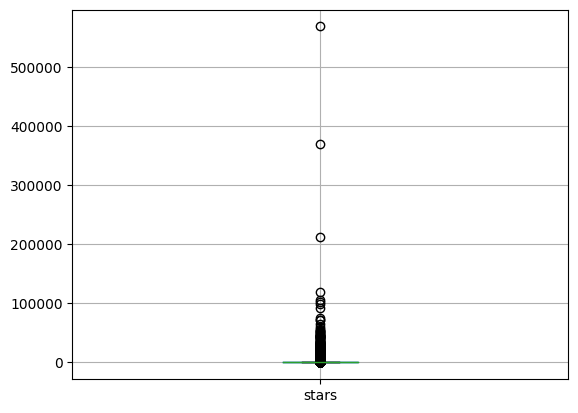

In [14]:
df_stars.boxplot()

## Conclusion
The GitHub stars' distribution is extremely skewed:
- 90% of the users have 0 or 1 star (aggregated across all their public repositories).
- 5% have 4 star or more.
- 1% have 30 stars or more.
- 0.1% have 410 stars or more.

Suggestion for thresholds:

| stat                  | bronze (90% quantile) | silver (99% quantile) | gold (99.9% quantile) |
|:----------------------|-----------------------|-----------------------|-----------------------|
| stars received #      | 1                     | 30                    | 400                   |
